In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

import cv2

import os

from numpy.random import seed
seed(1)

tf.random.set_seed(2)

In [2]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 2

CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 15

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 50
STEPS_PER_EPOCH_VALIDATION = 30

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 4
BATCH_SIZE_VALIDATION = 4

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [3]:
# resnet_weights_path = 'input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [4]:
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(InceptionV3(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False



87916544/87910968 [==============================] - 33s 0us/step


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [6]:
sgd = tf.keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)
# model.compile(optimizer = sgd, loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = LOSS_METRICS)

In [7]:
image_size = IMAGE_RESIZE
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(
        'res_data/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        'res_data/valid',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 520 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
# Max number of steps that these generator will have opportunity to process their source content
# len(train_generator) should be 'no. of available train images / BATCH_SIZE_TRAINING'
# len(valid_generator) should be 'no. of available train images / BATCH_SIZE_VALIDATION'
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(4, 130, 4, 25)

In [9]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction


cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'InceptionV3.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'max')

In [10]:
# Grid Search is an ideal candidate for distributed machine learning
# Pseudo code for hyperparameters Grid Search

'''
from sklearn.grid_search import ParameterGrid
param_grid = {'epochs': [5, 10, 15], 'steps_per_epoch' : [10, 20, 50]}

grid = ParameterGrid(param_grid)

# Accumulate history of all permutations (may be for viewing trend) and keep watching for lowest val_loss as final model
for params in grid:
    print(params)
'''

"\nfrom sklearn.grid_search import ParameterGrid\nparam_grid = {'epochs': [5, 10, 15], 'steps_per_epoch' : [10, 20, 50]}\n\ngrid = ParameterGrid(param_grid)\n\n# Accumulate history of all permutations (may be for viewing trend) and keep watching for lowest val_loss as final model\nfor params in grid:\n    print(params)\n"

In [11]:
fit_history = model.fit_generator(
        train_generator,
#         steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = 25,
        validation_data=validation_generator,
#         validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
130/130 [==============================] - 101s 776ms/step - loss: 1976.3307 - accuracy: 0.5173 - val_loss: 1190.7725 - val_accuracy: 0.6800
Epoch 2/25
130/130 [==============================] - 88s 673ms/step - loss: 1574.0961 - accuracy: 0.6365 - val_loss: 1413.0367 - val_accuracy: 0.5600
Epoch 3/25
130/130 [==============================] - 85s 651ms/step - loss: 1400.4845 - accuracy: 0.6135 - val_loss: 1163.0624 - val_accuracy: 0.6800
Epoch 4/25
130/130 [==============================] - 85s 653ms/step - loss: 1069.9894 - accuracy: 0.6827 - val_loss: 1306.3878 - val_accuracy: 0.6300
Epoch 5/25
130/130 [==============================] - 85s 654ms/step - loss: 997.4454 - accuracy: 0.7212 - val_loss: 1248.3250 - val_accuracy: 0.6400
Epoch 6/25
130/130 [==============================] - 85s 656ms/step - loss: 881.8461 - accuracy: 0.7038 - val_loss: 1067.8104 - val_accuracy: 0.6300
Epoch 7/25
130/130 

In [12]:
model.load_weights("Res_net.hdf5")

ValueError: Layer #0 (named "inception_v3" in the current model) was found to correspond to layer resnet50 in the save file. However the new layer inception_v3 expects 376 weights, but the saved weights have 318 elements.

In [13]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


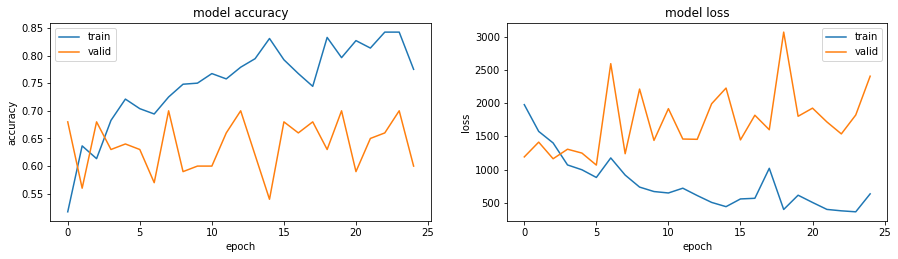

In [14]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()


In [15]:
# NOTE that flow_from_directory treats each sub-folder as a class which works fine for training data
# Actually class_mode=None is a kind of workaround for test data which too must be kept in a subfolder


# batch_size can be 1 or any factor of test dataset size to ensure that test dataset is samples just once, i.e., no data is left out
test_generator = data_generator.flow_from_directory(
    directory = 'res_data/test',
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

# Try batch size of 1+ in test_generator & check batch_index & filenames in resulting batches
'''
for i in test_generator:
    #print(test_generator.batch_index, test_generator.batch_size)
    idx = (test_generator.batch_index - 1) * test_generator.batch_size
    print(test_generator.filenames[idx : idx + test_generator.batch_size])
'''

Found 50 images belonging to 1 classes.


'\nfor i in test_generator:\n    #print(test_generator.batch_index, test_generator.batch_size)\n    idx = (test_generator.batch_index - 1) * test_generator.batch_size\n    print(test_generator.filenames[idx : idx + test_generator.batch_size])\n'

In [16]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

Instructions for updating:
Please use Model.predict, which supports generators.
50/50 [==============================] - 8s 156ms/step


Test Report 
-------------- 


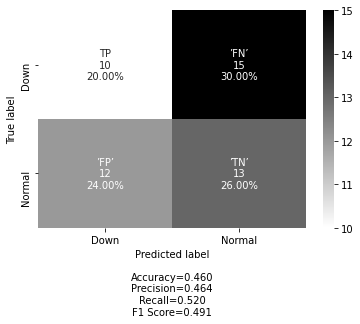

In [19]:
y_test = np.concatenate((np.zeros((25)),np.ones(25)))
## Confusion Matrix 
print("Test Report ")
print("-------------- ")

cf_matrix = confusion_matrix(y_test, predicted_class_indices)

import seaborn as sns
# sns.heatmap(cf_matrix, annot=True)

labels = ["TP","’FN’","’FP’","’TN’"]
categories = ["Down", "Normal"]
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap="binary")


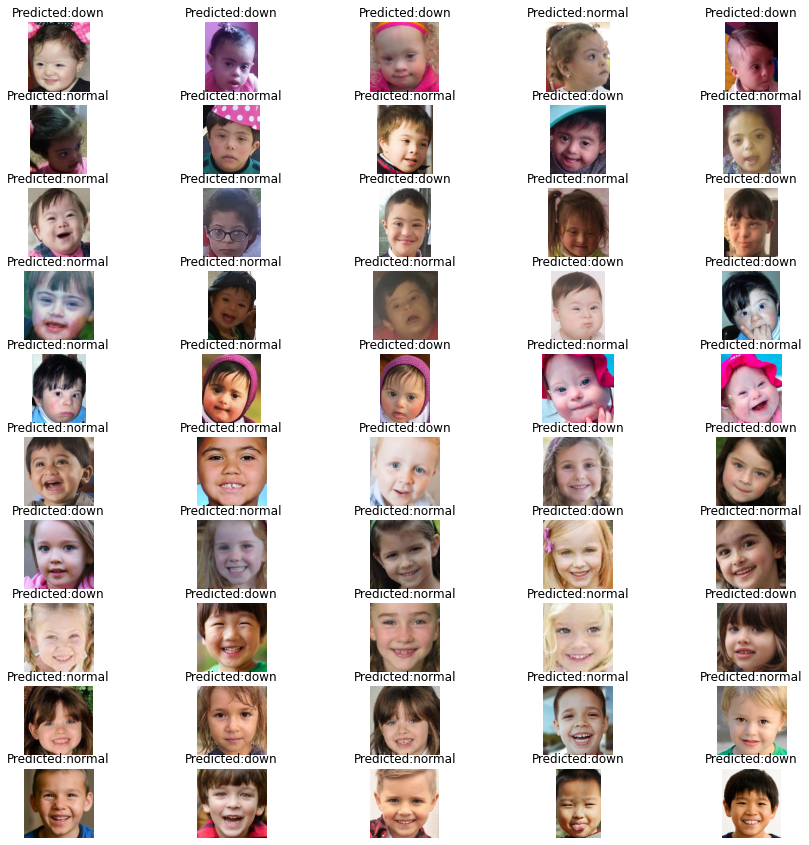

In [20]:
TEST_DIR = 'res_data/test/'
f, ax = plt.subplots(10, 5, figsize = (15, 15))
j = 0 
k = 0
for i in range(0,50):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    # a if condition else b
    predicted_class = "normal" if predicted_class_indices[i] else "down"

    ax[j , k ].imshow(imgRGB)
    ax[j , k ].axis('off')
    ax[j , k ].set_title("Predicted:{}".format(predicted_class))   
    k = k + 1 
    if(k == 5):
        k = 0
        j = j +1 

plt.show()

In [21]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)

results_df.to_csv('submission.csv', index=False)
results_df.head()


,id,label
0,310,0
1,311,0
2,312,0
3,313,1
4,314,0


In [18]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)